In [47]:
#default ml libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sklearn as sk
#tf libraries
import tensorflow as tf
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve
import itertools
import pandas as pd
import itertools
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, r2_score
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import seaborn as sns

In [48]:
# Load the test.csv file
train = pd.read_csv('train.csv')
print(train.head())

   id  person_age  person_income person_home_ownership  person_emp_length  \
0   0          37          35000                  RENT                0.0   
1   1          22          56000                   OWN                6.0   
2   2          29          28800                   OWN                8.0   
3   3          30          70000                  RENT               14.0   
4   4          22          60000                  RENT                2.0   

  loan_intent loan_grade  loan_amnt  loan_int_rate  loan_percent_income  \
0   EDUCATION          B       6000          11.49                 0.17   
1     MEDICAL          C       4000          13.35                 0.07   
2    PERSONAL          A       6000           8.90                 0.21   
3     VENTURE          B      12000          11.11                 0.17   
4     MEDICAL          A       6000           6.92                 0.10   

  cb_person_default_on_file  cb_person_cred_hist_length  loan_status  
0              

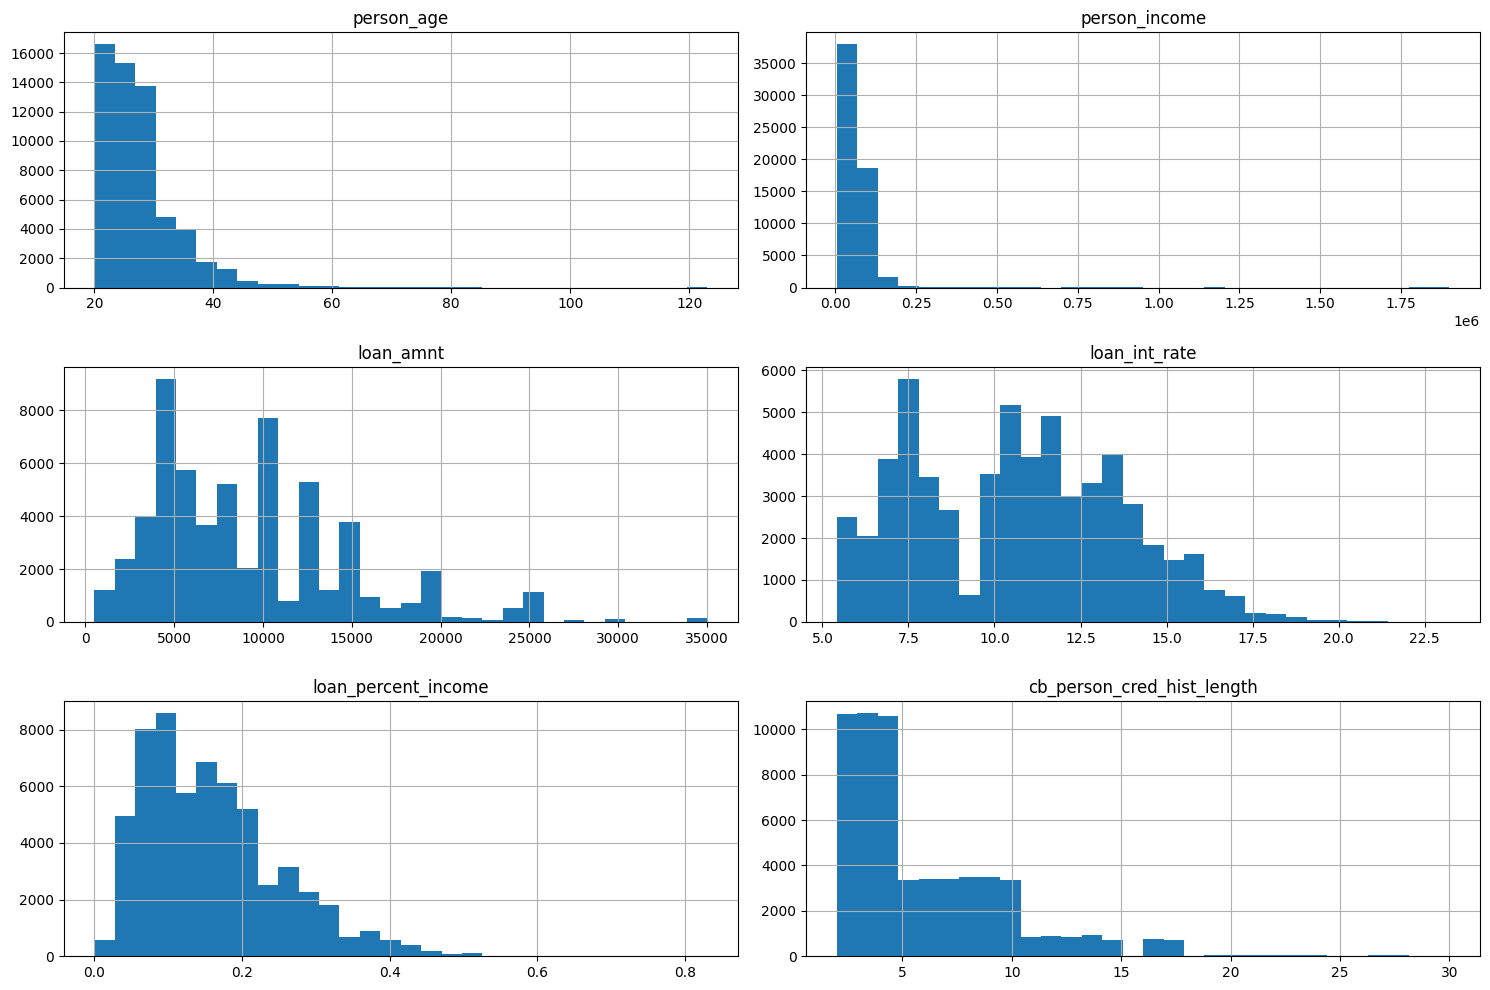

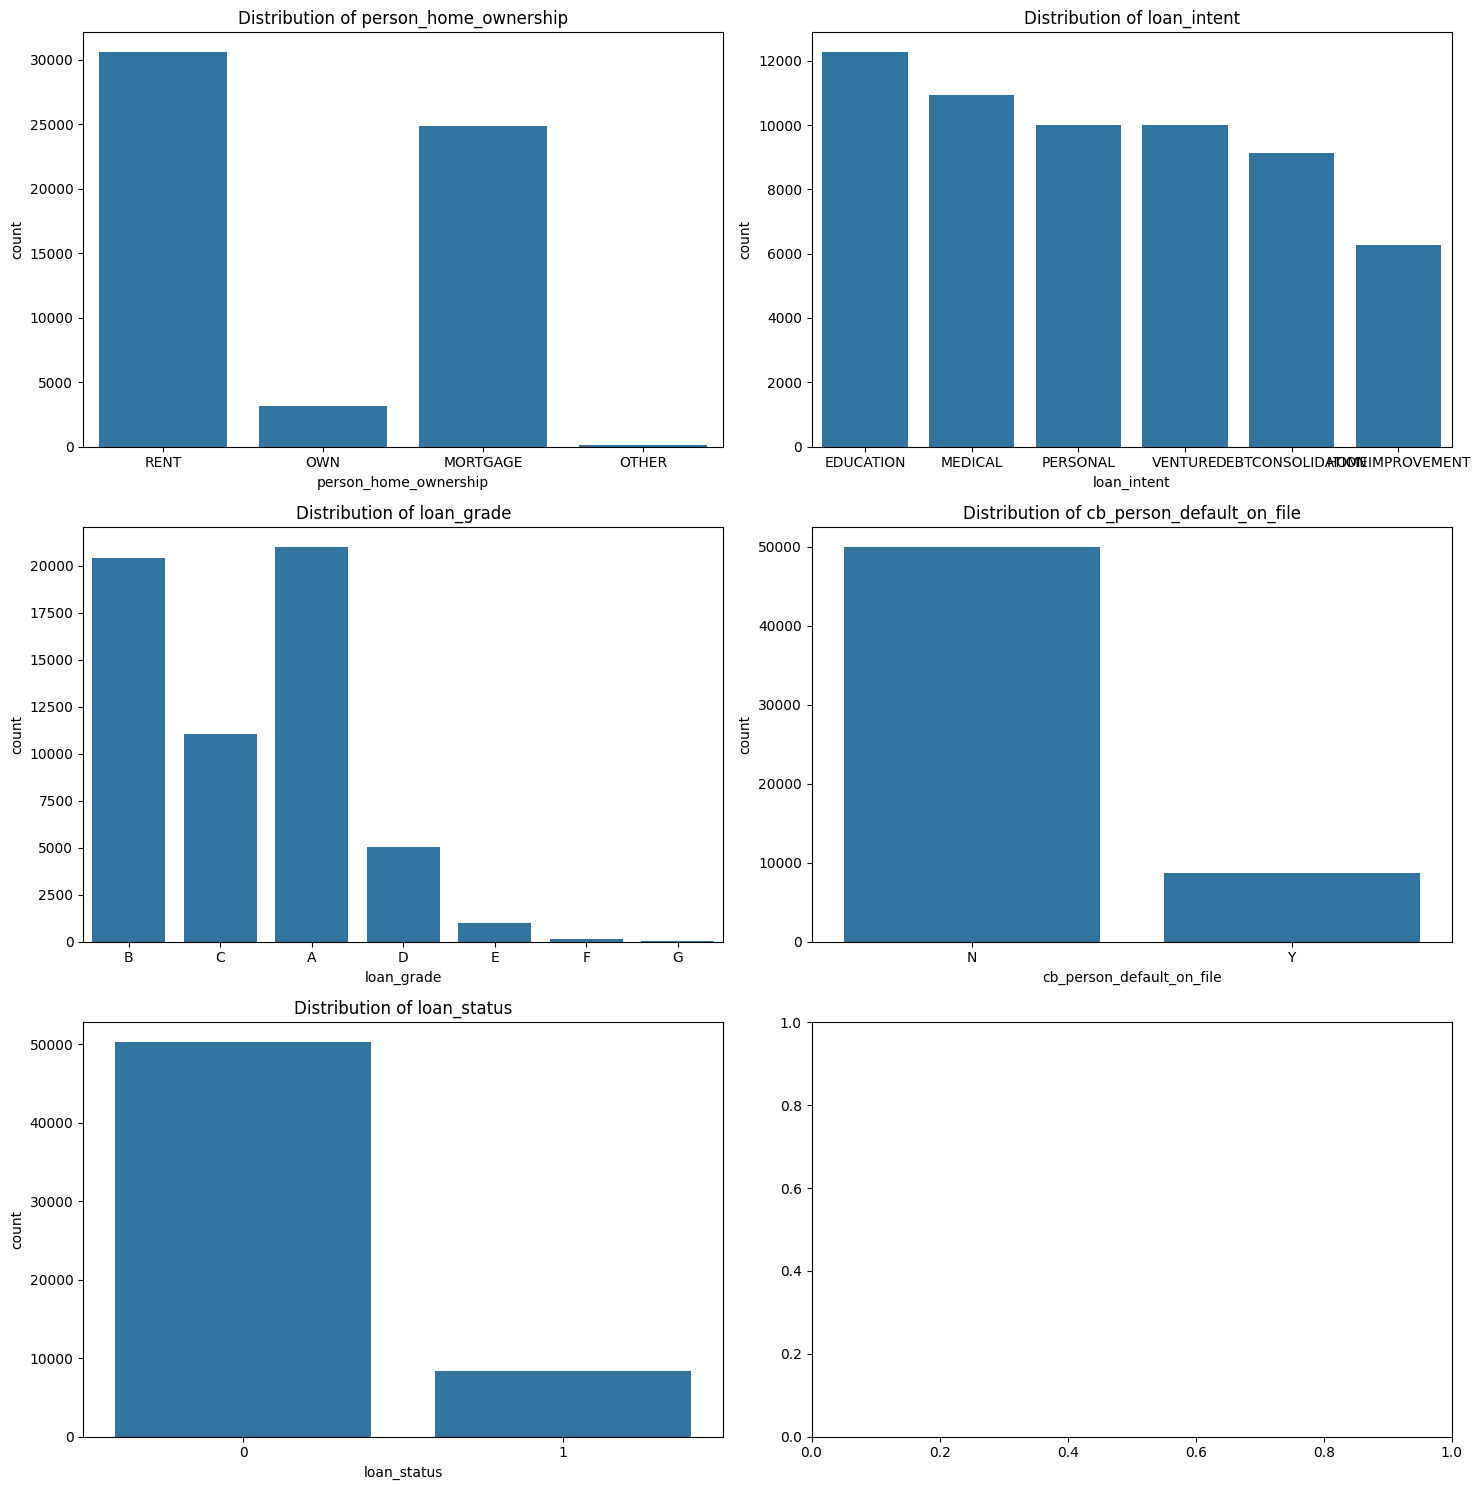

In [49]:


# Plot histograms for numerical columns
numerical_columns = ['person_age', 'person_income', 'loan_amnt', 'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length']
train[numerical_columns].hist(bins=30, figsize=(15, 10))
plt.tight_layout()
plt.show()

# Plot count plots for categorical columns
categorical_columns = ['person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file', 'loan_status']
fig, axes = plt.subplots(3, 2, figsize=(15, 15))  # Adjusted to 3x2 grid
for ax, col in zip(axes.flatten(), categorical_columns):
    sns.countplot(data=train, x=col, ax=ax)
    ax.set_title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

In [50]:


# Define the features and target
features = ['person_age', 'person_income', 'person_home_ownership', 'person_emp_length', 'loan_intent', 'loan_grade', 'loan_amnt', 'loan_int_rate', 'loan_percent_income', 'cb_person_default_on_file', 'cb_person_cred_hist_length']
target = ['loan_status']  # Replace with the actual target column name

# Preprocess the data
X = train[features]
y = train[target]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Define the preprocessing for numerical and categorical features
numerical_features = ['person_age', 'person_income', 'person_emp_length', 'loan_amnt', 'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length']
categorical_features = ['person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file']

numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Preprocess the data
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)


print(X_test.shape)
print(y_test.head())
print(y_test.shape)
print(y_train.head())
print(y_train.shape)
print(X_train.shape)
# Hardcoded array


(17594, 26)
       loan_status
4657             0
56440            0
42117            1
10849            0
39395            0
(17594, 1)
       loan_status
52748            0
7648             0
4217             1
37793            0
28209            1
(41051, 1)
(41051, 26)


In [51]:
# Print the shapes of the datasets
print(f'X_test shape: {X_test.shape}')
print(f'y_test shape: {y_test.shape}')
print(f'X_train shape: {X_train.shape}')
print(f'y_train shape: {y_train.shape}')

# Print the first few rows of y_test and y_train without indices
print('y_test values:')
print(y_test.values[:5])

print('y_train values:')
print(y_train.values[:5])

X_test shape: (17594, 26)
y_test shape: (17594, 1)
X_train shape: (41051, 26)
y_train shape: (41051, 1)
y_test values:
[[0]
 [0]
 [1]
 [0]
 [0]]
y_train values:
[[0]
 [0]
 [1]
 [0]
 [1]]


In [52]:
class CustomModel:
    def __init__(self, layer_sizes):
        self.model = tf.keras.Sequential()
        self.model.add(tf.keras.layers.InputLayer(input_shape=(X_train.shape[1],)))
        
        for units in reversed(sorted(layer_sizes)):
            self.model.add(tf.keras.layers.Dense(units, activation='relu'))
        
        self.model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
        self.model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    def fit(self, X_train, y_train, X_test, y_test, epochs=1,verbose=0,batch_size=32):
        self.model.fit(X_train, y_train, epochs=epochs, validation_data=(X_test, y_test), verbose=verbose,batch_size=batch_size)
    
    def evaluate(self, X_test, y_test):
        return self.model.evaluate(X_test, y_test, verbose=0)
    
    def predict(self, X_test):
        y_pred_prob = self.model.predict(X_test)
        return (y_pred_prob > 0.5).astype(int)
    
    def summary(self):
        self.model.summary()

In [53]:
import itertools
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.metrics import roc_auc_score, r2_score
import gc
# Assuming CustomModel class and other necessary code is already defined

array = [256, 128, 64, 32, 16, 8, 4]

# batch_sizes = [16, 32, 64]
# epoch_values = [1, 5, 10]
batch_sizes = [32] 
epoch_values = [5]
# Generate the power set of the array
# power_set = list(itertools.chain.from_iterable(itertools.combinations(array, r) for r in range(1, len(array) + 1)))
# power_set = [[512,256, 128, 64, 32, 16, 8, 4],[512,256, 128, 64, 32, 16, 8],
#              [512,256, 128, 64, 32, 16],[512,256, 128, 64, 32],[512,256, 128, 64],
#              [512,256, 128],[512,256],[512]]
power_set = [[4,3,2]]
# Initialize variables to keep track of the best model
best_model = None
best_roc_auc = 0

# Loop to add layers, batch sizes, and epochs, and evaluate the model
for subset in power_set:
    for batch_size in batch_sizes:
        for epochs in epoch_values:
            custom_model = CustomModel(subset)
            
            # Train the model
            custom_model.fit(X_train, y_train, X_test, y_test, epochs=epochs, batch_size=batch_size)
            
            # Evaluate the model
            loss, accuracy = custom_model.evaluate(X_test, y_test)
            
            # Predict probabilities for the test set
            y_pred = custom_model.predict(X_test)
            
            # Calculate the ROC AUC score
            roc_auc = roc_auc_score(y_test, y_pred)
            
            # Calculate the R² score
            r2 = r2_score(y_test, y_pred)
            
            # Print the metrics
            print(f'Layers: {subset}, Batch Size: {batch_size}, Epochs: {epochs}')
            print(f'  Loss: {loss}')
            print(f'  Accuracy: {accuracy}')
            print(f'  ROC AUC: {roc_auc}')
            print(f'  R² score: {r2}')
            
            # Check if this model is the best so far
            if roc_auc > best_roc_auc:
                best_roc_auc = roc_auc
                best_model = custom_model
                custom_model.model.save("bm.keras")
            gc.collect()

# Print the best model summary
print("Best Model Summary:")
best_model.summary()

C:\Users\death\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


550/550 ━━━━━━━━━━━━━━━━━━━━ 0s 616us/step
Layers: [4, 3, 2], Batch Size: 32, Epochs: 5
  Loss: 0.20714923739433289
  Accuracy: 0.9328179955482483
  ROC AUC: 0.8127524043844777
  R² score: 0.44292609824636753
Best Model Summary:


Model: "sequential_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_117 (Dense)               │ (None, 4)              │           108 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_118 (Dense)               │ (None, 3)              │            15 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_119 (Dense)               │ (None, 2)              │             8 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_120 (Dense)               │ (None, 1)              │             3 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 404 (1.58 KB)

 Trainable params: 134 (536.00 B)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 270 (1.06 KB)

550/550 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step
[[0]
 [0]
 [0]
 ...
 [0]
 [0]
 [0]]
Number of predictions equal to 0: 15692
Number of predictions equal to 1: 1902


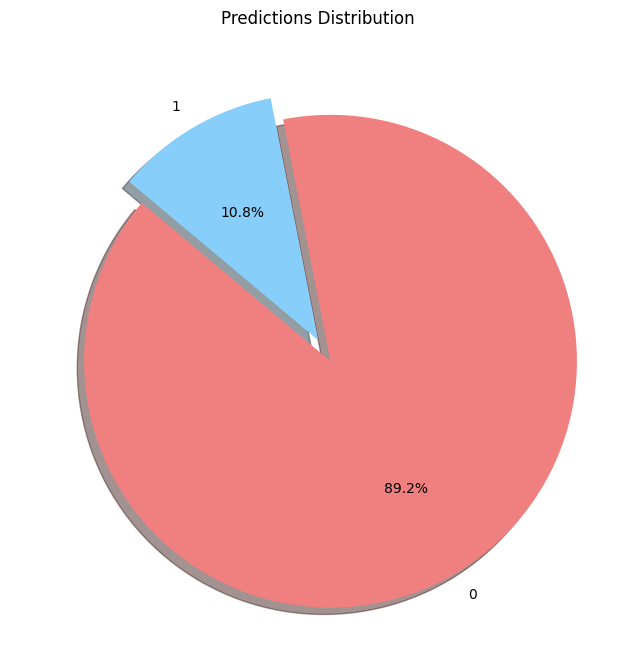

In [54]:


# Predict the values using the best model
y_pred = best_model.predict(X_test)
print(y_pred)

# Count the number of predictions that are 0 and 1
count_0 = (y_pred == 0).sum()
count_1 = (y_pred == 1).sum()

# Print the counts
print(f'Number of predictions equal to 0: {count_0}')
print(f'Number of predictions equal to 1: {count_1}')

# Create a pie chart
labels = ['0', '1']
sizes = [count_0, count_1]
colors = ['lightcoral', 'lightskyblue']
explode = (0.1, 0)  # explode the first slice

plt.figure(figsize=(8, 8))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
plt.title('Predictions Distribution')
plt.show()

Confusion Matrix:
[[14818   308]
 [  874  1594]]


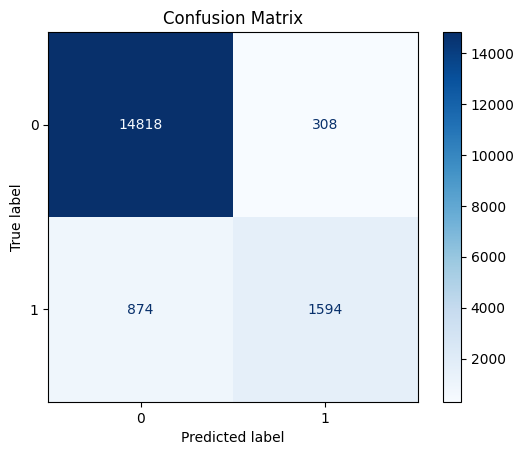

R² score: 0.44292609824636753
Best ROC AUC score: 0.8127524043844777


In [55]:
cm = confusion_matrix(y_test, y_pred)

# Print the confusion matrix
print("Confusion Matrix:")
print(cm)

# Visualize the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

# Calculate and print the R² score
r2 = r2_score(y_test, y_pred)
print(f'R² score: {r2}')

# Print the best ROC AUC score
print(f'Best ROC AUC score: {best_roc_auc}')

In [56]:
#load model from bm.keras and predict and find r2 rocaucscore and confusion matrix for x_test and y_test

import tensorflow as tf
from sklearn.metrics import r2_score, roc_auc_score, confusion_matrix
import pandas as pd

# Load the model from bm.keras
model = tf.keras.models.load_model('bm.keras')

# Predict on the test data
y_pred_prob = model.predict(X_test)

# Apply threshold of 0.5 to get binary predictions
y_pred = (y_pred_prob > 0.5).astype(int)

# Calculate R² score
r2 = r2_score(y_test, y_pred)

# Calculate ROC AUC score
roc_auc = roc_auc_score(y_test, y_pred_prob)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Print the results
print(f'R² Score: {r2}')
print(f'ROC AUC Score: {roc_auc}')
print('Confusion Matrix:')
print(conf_matrix)

550/550 ━━━━━━━━━━━━━━━━━━━━ 0s 753us/step
R² Score: 0.44292609824636753
ROC AUC Score: 0.9190204765116189
Confusion Matrix:
[[14818   308]
 [  874  1594]]


In [57]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Reshape

# Reshape the data
X_train_reshaped = X_train.reshape((X_train.shape[0], X_train.shape[1], 1, 1))
X_test_reshaped = X_test.reshape((X_test.shape[0], X_test.shape[1], 1, 1))

# Define the CNN model
model = Sequential([
    Conv2D(32, (3, 1), activation='relu', input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2], 1)),  # First convolutional layer
    MaxPooling2D(pool_size=(2, 1)),  # First max pooling layer
    Dropout(0.25),  # First dropout layer
    Conv2D(64, (3, 1), activation='relu'),  # Second convolutional layer
    MaxPooling2D(pool_size=(2, 1)),  # Second max pooling layer
    Dropout(0.25),  # Second dropout layer
    Conv2D(128, (3, 1), activation='relu'),  # Third convolutional layer
    MaxPooling2D(pool_size=(2, 1)),  # Third max pooling layer
    Dropout(0.25),  # Third dropout layer
    Flatten(),  # Flatten the data for the dense layers
    Dense(256, activation='relu'),  # First dense layer
    Dropout(0.5),  # Fourth dropout layer
    Dense(128, activation='relu'),  # Second dense layer
    Dropout(0.5),  # Fifth dropout layer
    Dense(1, activation='sigmoid')  # Output layer
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()
# Train the model
model.fit(X_train_reshaped, y_train, epochs=10, batch_size=32, validation_data=(X_test_reshaped, y_test))

# Evaluate the model
loss, accuracy = model.evaluate(X_test_reshaped, y_test)
print(f'Loss: {loss}, Accuracy: {accuracy}')
#r2 and roc_auc

# Predict probabilities for the test set
y_pred_prob = model.predict(X_test_reshaped)

# Apply threshold of 0.5 to get binary predictions
y_pred = (y_pred_prob > 0.5).astype(int)

# Calculate R² score
r2 = r2_score(y_test, y_pred)
# Calculate ROC AUC score
roc_auc = roc_auc_score(y_test, y_pred_prob)
# Print the results
print(f'R² Score: {r2}')
print(f'ROC AUC Score: {roc_auc}')

C:\Users\death\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_38 (Conv2D)              │ (None, 24, 1, 32)      │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 12, 1, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_68 (Dropout)            │ (None, 12, 1, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_39 (Conv2D)              │ (None, 10, 1, 64)      │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 5, 1, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_69 (Dropout)            │ (None, 5, 1, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_40 (Conv2D)              │ (None, 3, 1, 128)      │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 1, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_70 (Dropout)            │ (None, 1, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_14 (Flatten)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_121 (Dense)               │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_71 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_122 (Dense)               │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_72 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_123 (Dense)               │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 97,089 (379.25 KB)

 Trainable params: 97,089 (379.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1283/1283 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.8813 - loss: 0.3183 - val_accuracy: 0.9291 - val_loss: 0.2200
Epoch 2/10
1283/1283 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.9177 - loss: 0.2430 - val_accuracy: 0.9354 - val_loss: 0.2057
Epoch 3/10
1283/1283 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.9238 - loss: 0.2312 - val_accuracy: 0.9367 - val_loss: 0.1961
Epoch 4/10
1283/1283 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.9263 - loss: 0.2238 - val_accuracy: 0.9401 - val_loss: 0.1905
Epoch 5/10
1283/1283 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.9331 - loss: 0.2138 - val_accuracy: 0.9416 - val_loss: 0.1903
Epoch 6/10
1283/1283 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.9328 - loss: 0.2124 - val_accuracy: 0.9408 - val_loss: 0.1885
Epoch 7/10
1283/1283 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.9304 - loss: 0.2166 - val_accuracy: 0.9438 - val_loss: 0.1874
Epoch 8/10
1283/1283 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.9351 - loss: 0.2063 - 

C:\Users\death\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_44 (Conv2D)              │ (None, 24, 1, 128)     │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_17            │ (None, 12, 1, 128)     │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_78 (Dropout)            │ (None, 12, 1, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_45 (Conv2D)              │ (None, 10, 1, 64)      │        24,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_18            │ (None, 5, 1, 64)       │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_79 (Dropout)            │ (None, 5, 1, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_46 (Conv2D)              │ (None, 3, 1, 32)       │         6,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_19            │ (None, 1, 1, 32)       │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_80 (Dropout)            │ (None, 1, 1, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_16 (Flatten)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_127 (Dense)               │ (None, 256)            │         8,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_81 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_128 (Dense)               │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_82 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_129 (Dense)               │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 72,801 (284.38 KB)

 Trainable params: 72,801 (284.38 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1283/1283 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.8788 - loss: 0.3276 - val_accuracy: 0.9307 - val_loss: 0.2107
Epoch 2/10
1283/1283 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.9198 - loss: 0.2367 - val_accuracy: 0.9347 - val_loss: 0.2038
Epoch 3/10
1283/1283 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.9254 - loss: 0.2276 - val_accuracy: 0.9384 - val_loss: 0.1984
Epoch 4/10
1283/1283 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.9293 - loss: 0.2202 - val_accuracy: 0.9387 - val_loss: 0.1955
Epoch 5/10
1283/1283 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.9306 - loss: 0.2164 - val_accuracy: 0.9394 - val_loss: 0.1939
Epoch 6/10
1283/1283 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.9334 - loss: 0.2127 - val_accuracy: 0.9406 - val_loss: 0.1922
Epoch 7/10
1283/1283 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.9327 - loss: 0.2126 - val_accuracy: 0.9404 - val_loss: 0.1916
Epoch 8/10
1283/1283 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.9366 - loss: 0.2054 - 

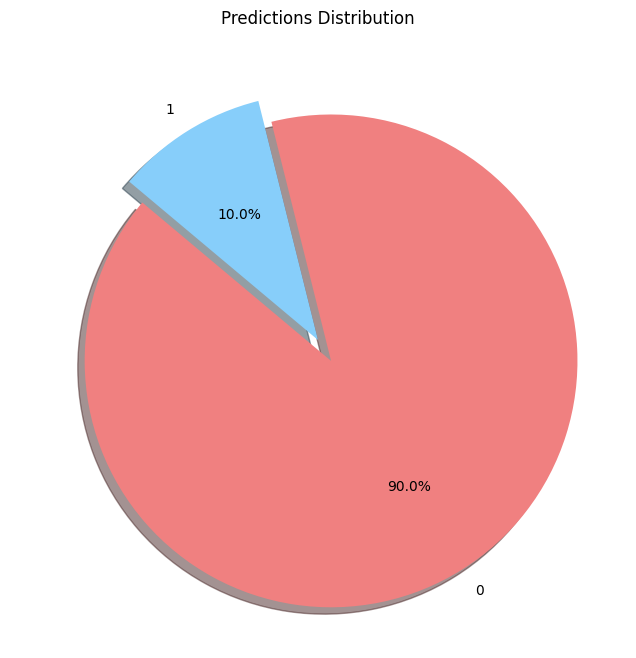

In [59]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Reshape ,AvgPool2D
from tensorflow.keras.models import Sequential
from sklearn.metrics import r2_score, roc_auc_score, confusion_matrix

# Reshape the data
X_train_reshaped = X_train.reshape((X_train.shape[0], X_train.shape[1], 1, 1))
X_test_reshaped = X_test.reshape((X_test.shape[0], X_test.shape[1], 1, 1))

# Define the CNN model
convmodel2 = Sequential([
    Conv2D(128, (3, 1), activation='relu', input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2], 1)),  # First convolutional layer
    AvgPool2D(pool_size=(2, 1)),  # First max pooling layer
    Dropout(0.25),  # First dropout layer
    Conv2D(64, (3, 1), activation='relu'),  # Second convolutional layer
    AvgPool2D(pool_size=(2, 1)),  # Second max pooling layer
    Dropout(0.25),  # Second dropout layer
    Conv2D(32, (3, 1), activation='relu'),  # Third convolutional layer
    AvgPool2D(pool_size=(2, 1)),  # Third max pooling layer
    Dropout(0.25),  # Third dropout layer
    Flatten(),  # Flatten the data for the dense layers
    Dense(256, activation='relu'),  # First dense layer
    Dropout(0.5),  # Fourth dropout layer
    Dense(128, activation='relu'),  # Second dense layer
    Dropout(0.5),  # Fifth dropout layer
    Dense(1, activation='sigmoid')  # Output layer
])

# Compile the model
convmodel2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print the model summary
convmodel2.summary()

# Train the model
convmodel2.fit(X_train_reshaped, y_train, epochs=10, batch_size=32, validation_data=(X_test_reshaped, y_test))

# Evaluate the model
loss, accuracy = convmodel2.evaluate(X_test_reshaped, y_test)
print(f'Loss: {loss}, Accuracy: {accuracy}')

# Predict probabilities for the test set
y_pred_prob = convmodel2.predict(X_test_reshaped)

# Apply threshold of 0.5 to get binary predictions
y_pred = (y_pred_prob > 0.5).astype(int)

# Calculate R² score
r2 = r2_score(y_test, y_pred)

# Calculate ROC AUC score
roc_auc = roc_auc_score(y_test, y_pred_prob)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Print the results
print(f'R² Score: {r2}')
print(f'ROC AUC Score: {roc_auc}')
print('Confusion Matrix:')
print(conf_matrix)

import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import r2_score, roc_auc_score, confusion_matrix

# Load the test.csv file
test = pd.read_csv('test.csv')
print(test.head())

# Define the features (assuming features is already defined)
features = ['person_age', 'person_income', 'person_home_ownership', 'person_emp_length',
            'loan_intent', 'loan_grade', 'loan_amnt', 'loan_int_rate', 'loan_percent_income',
            'cb_person_default_on_file', 'cb_person_cred_hist_length']

# Extract IDs and features
ids = test['id']  # Assuming 'id' is the column name for IDs in the test.csv file
X = test[features]

# Preprocess the data
X = preprocessor.transform(X)

# Predict the values using convmodel2
y_pred = convmodel2.predict(X.reshape((X.shape[0], X.shape[1], 1, 1)))

# Apply threshold of 0.5 to get binary predictions
y_pred = (y_pred > 0.5).astype(int)
print(y_pred.shape, y_pred.flatten().shape)

# Combine IDs and predictions into a DataFrame
predictions_df = pd.DataFrame({'id': ids, 'prediction': y_pred.flatten()})

# Print the DataFrame
print(predictions_df)

# Count the number of predictions greater than 0.5 and less than or equal to 0.5
count_greater_than_0_5 = (y_pred > 0.5).sum()
count_less_than_or_equal_0_5 = (y_pred <= 0.5).sum()

# Print the counts
print(f'Number of predictions greater than 0.5: {count_greater_than_0_5}')
print(f'Number of predictions less than or equal to 0.5: {count_less_than_or_equal_0_5}')

# Plot a pie chart showing the percentages
labels = ['0', '1']
sizes = [count_less_than_or_equal_0_5, count_greater_than_0_5]
colors = ['lightcoral', 'lightskyblue']
explode = (0.1, 0)  # explode the first slice

plt.figure(figsize=(8, 8))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
plt.title('Predictions Distribution')
plt.show()

# Save the predictions to CSV with (id, prediction)
predictions_df.to_csv('convmid.csv', index=False)



      id  person_age  person_income person_home_ownership  person_emp_length  \
0  58645          23          69000                  RENT                3.0   
1  58646          26          96000              MORTGAGE                6.0   
2  58647          26          30000                  RENT                5.0   
3  58648          33          50000                  RENT                4.0   
4  58649          26         102000              MORTGAGE                8.0   

         loan_intent loan_grade  loan_amnt  loan_int_rate  \
0    HOMEIMPROVEMENT          F      25000          15.76   
1           PERSONAL          C      10000          12.68   
2            VENTURE          E       4000          17.19   
3  DEBTCONSOLIDATION          A       7000           8.90   
4    HOMEIMPROVEMENT          D      15000          16.32   

   loan_percent_income cb_person_default_on_file  cb_person_cred_hist_length  
0                 0.36                         N                         

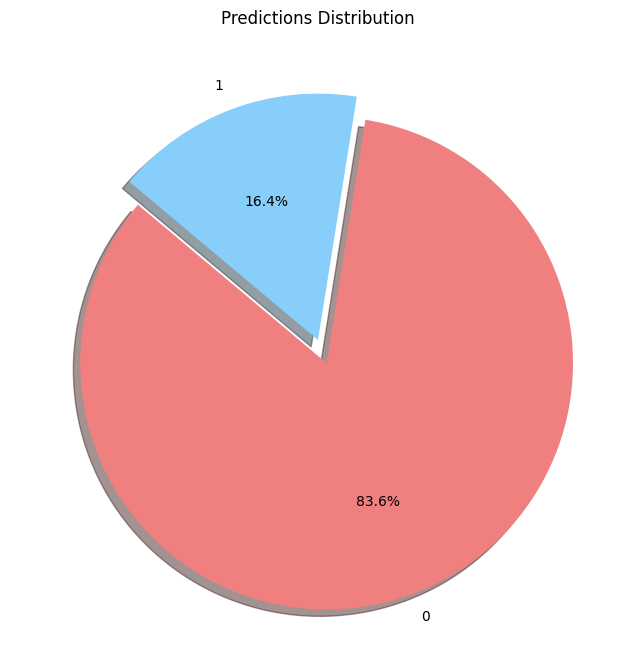

In [60]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from sklearn.preprocessing import StandardScaler

# Load the test.csv file
test = pd.read_csv('test.csv')
print(test.head())

# Define the features (assuming features is already defined)
features = ['person_age', 'person_income', 'person_home_ownership', 'person_emp_length',
            'loan_intent', 'loan_grade', 'loan_amnt', 'loan_int_rate', 'loan_percent_income',
            'cb_person_default_on_file', 'cb_person_cred_hist_length']

# Extract IDs and features
ids = test['id']  # Assuming 'id' is the column name for IDs in the test.csv file
X = test[features]

# Preprocess the data

X = preprocessor.transform(X)

# Define the autoencoder model
input_dim = X.shape[1]
encoding_dim = 64  # Dimension of the encoded representation

# Encoder
input_layer = Input(shape=(input_dim,))
encoded = Dense(encoding_dim, activation='relu')(input_layer)

# Decoder
decoded = Dense(input_dim, activation='sigmoid')(encoded)

# Autoencoder
autoencoder = Model(input_layer, decoded)

# Compile the model
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

# Train the model
autoencoder.fit(X, X, epochs=5, batch_size=32, validation_split=0.2)

# Predict the values using the autoencoder
y_pred = autoencoder.predict(X)

# Apply threshold of 0.5 to get binary predictions
y_pred = (y_pred > 0.5).astype(int)

# Ensure y_pred has the correct shape
y_pred = y_pred[:, 0] if y_pred.shape[1] == 1 else y_pred.flatten()
print(y_pred.shape, ids.shape)

# Combine IDs and predictions into a DataFrame
predictions_df = pd.DataFrame({'id': ids, 'prediction': y_pred[:len(ids)]})

# Print the DataFrame
print(predictions_df)

# Count the number of predictions greater than 0.5 and less than or equal to 0.5
count_greater_than_0_5 = (y_pred > 0.5).sum()
count_less_than_or_equal_0_5 = (y_pred <= 0.5).sum()

# Print the counts
print(f'Number of predictions greater than 0.5: {count_greater_than_0_5}')
print(f'Number of predictions less than or equal to 0.5: {count_less_than_or_equal_0_5}')

# Plot a pie chart showing the percentages
labels = ['0', '1']
sizes = [count_less_than_or_equal_0_5, count_greater_than_0_5]
colors = ['lightcoral', 'lightskyblue']
explode = (0.1, 0)  # explode the first slice

plt.figure(figsize=(8, 8))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
plt.title('Predictions Distribution')
plt.show()

# Save the predictions to CSV with (id, prediction)
predictions_df.to_csv('automid.csv', index=False)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Flatten, Dense, Dropout, Reshape, AvgPool2D
from tensorflow.keras.models import Sequential
from sklearn.metrics import r2_score, roc_auc_score, confusion_matrix

# Reshape the data
X_train_reshaped = X_train.reshape((X_train.shape[0], X_train.shape[1], 1, 1))
X_test_reshaped = X_test.reshape((X_test.shape[0], X_test.shape[1], 1, 1))

# Define the encoder-decoder model
encoder_decoder_model = Sequential([
    # Encoder
    Conv2D(128, (3, 1), activation='relu', input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2], 1)),  # First convolutional layer
    AvgPool2D(pool_size=(2, 1)),  # First average pooling layer
    Dropout(0.25),  # First dropout layer
    Conv2D(64, (3, 1), activation='relu'),  # Second convolutional layer
    AvgPool2D(pool_size=(2, 1)),  # Second average pooling layer
    Dropout(0.25),  # Second dropout layer
    Conv2D(32, (3, 1), activation='relu'),  # Third convolutional layer
    AvgPool2D(pool_size=(2, 1)),  # Third average pooling layer
    Dropout(0.25),  # Third dropout layer
    Flatten(),  # Flatten the data for the dense layers
    Dense(256, activation='relu'),  # First dense layer
    Dropout(0.5),  # Fourth dropout layer
    Dense(128, activation='relu'),  # Second dense layer
    Dropout(0.5),  # Fifth dropout layer
    
    # Decoder
    Reshape((16, 1, 8)),  # Reshape to match the input shape of the decoder
    UpSampling2D(size=(2, 1)),  # First upsampling layer
    Conv2D(32, (3, 1), activation='relu'),  # First convolutional layer in decoder
    UpSampling2D(size=(2, 1)),  # Second upsampling layer
    Conv2D(64, (3, 1), activation='relu'),  # Second convolutional layer in decoder
    UpSampling2D(size=(2, 1)),  # Third upsampling layer
    Conv2D(128, (3, 1), activation='relu'),  # Third convolutional layer in decoder
    Flatten(),  # Flatten the data for the final dense layer
    Dense(1, activation='sigmoid')  # Output layer
])

# Compile the model
encoder_decoder_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print the model summary
encoder_decoder_model.summary()

# Train the model
encoder_decoder_model.fit(X_train_reshaped, y_train, epochs=10, batch_size=32, validation_data=(X_test_reshaped, y_test))

# Evaluate the model
loss, accuracy = encoder_decoder_model.evaluate(X_test_reshaped, y_test)
print(f'Loss: {loss}, Accuracy: {accuracy}')

# Predict probabilities for the test set
y_pred_prob = encoder_decoder_model.predict(X_test_reshaped)

# Apply threshold of 0.5 to get binary predictions
y_pred = (y_pred_prob > 0.5).astype(int)

# Calculate R² score
r2 = r2_score(y_test, y_pred)

# Calculate ROC AUC score
roc_auc = roc_auc_score(y_test, y_pred_prob)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Print the results
print(f'R² Score: {r2}')
print(f'ROC AUC Score: {roc_auc}')
print('Confusion Matrix:')
print(conf_matrix)

# Load the test.csv file
test = pd.read_csv('test.csv')
print(test.head())

# Define the features (assuming features is already defined)
features = ['person_age', 'person_income', 'person_home_ownership', 'person_emp_length',
            'loan_intent', 'loan_grade', 'loan_amnt', 'loan_int_rate', 'loan_percent_income',
            'cb_person_default_on_file', 'cb_person_cred_hist_length']

# Extract IDs and features
ids = test['id']  # Assuming 'id' is the column name for IDs in the test.csv file
X = test[features]

# Preprocess the data
X = preprocessor.transform(X)

# Predict the values using encoder_decoder_model
y_pred = encoder_decoder_model.predict(X.reshape((X.shape[0], X.shape[1], 1, 1)))

# Apply threshold of 0.5 to get binary predictions
y_pred = (y_pred > 0.5).astype(int)
print(y_pred.shape, y_pred.flatten().shape)

# Combine IDs and predictions into a DataFrame
predictions_df = pd.DataFrame({'id': ids, 'prediction': y_pred.flatten()})

# Print the DataFrame
print(predictions_df)

# Count the number of predictions greater than 0.5 and less than or equal to 0.5
count_greater_than_0_5 = (y_pred > 0.5).sum()
count_less_than_or_equal_0_5 = (y_pred <= 0.5).sum()

# Print the counts
print(f'Number of predictions greater than 0.5: {count_greater_than_0_5}')
print(f'Number of predictions less than or equal to 0.5: {count_less_than_or_equal_0_5}')

# Plot a pie chart showing the percentages
labels = ['0', '1']
sizes = [count_less_than_or_equal_0_5, count_greater_than_0_5]
colors = ['lightcoral', 'lightskyblue']
explode = (0.1, 0)  # explode the first slice

plt.figure(figsize=(8, 8))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
plt.title('Predictions Distribution')
plt.show()

# Save the predictions to CSV with (id, prediction)
predictions_df.to_csv('convmid.csv', index=False)

C:\Users\death\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_47 (Conv2D)              │ (None, 24, 1, 128)     │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_20            │ (None, 12, 1, 128)     │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_83 (Dropout)            │ (None, 12, 1, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_48 (Conv2D)              │ (None, 10, 1, 64)      │        24,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_21            │ (None, 5, 1, 64)       │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_84 (Dropout)            │ (None, 5, 1, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_49 (Conv2D)              │ (None, 3, 1, 32)       │         6,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_22            │ (None, 1, 1, 32)       │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_85 (Dropout)            │ (None, 1, 1, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_17 (Flatten)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_132 (Dense)               │ (None, 256)            │         8,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_86 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_133 (Dense)               │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_87 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_3 (Reshape)             │ (None, 16, 1, 8)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_8 (UpSampling2D)  │ (None, 32, 1, 8)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_50 (Conv2D)              │ (None, 30, 1, 32)      │           800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_9 (UpSampling2D)  │ (None, 60, 1, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_51 (Conv2D)              │ (None, 58, 1, 64)      │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_10 (UpSampling2D) │ (None, 116, 1, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_52 (Conv2D)              │ (None, 114, 1, 128)    │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_18 (Flatten)            │ (None, 14592)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_134 (Dense)               │ (None, 1)              │        14,593 │
└─────────────────────────────────┴────────────────────────┴─────────────

 Total params: 118,977 (464.75 KB)

 Trainable params: 118,977 (464.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1283/1283 ━━━━━━━━━━━━━━━━━━━━ 16s 10ms/step - accuracy: 0.8802 - loss: 0.3204 - val_accuracy: 0.9219 - val_loss: 0.2585
Epoch 2/10
1283/1283 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - accuracy: 0.9205 - loss: 0.2375 - val_accuracy: 0.9226 - val_loss: 0.2816
Epoch 3/10
1283/1283 ━━━━━━━━━━━━━━━━━━━━ 15s 11ms/step - accuracy: 0.9265 - loss: 0.2288 - val_accuracy: 0.9347 - val_loss: 0.2177
Epoch 4/10
1283/1283 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - accuracy: 0.9288 - loss: 0.2216 - val_accuracy: 0.9388 - val_loss: 0.2075
Epoch 5/10
1283/1283 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - accuracy: 0.9315 - loss: 0.2146 - val_accuracy: 0.9384 - val_loss: 0.1979
Epoch 6/10
1283/1283 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - accuracy: 0.9308 - loss: 0.2166 - val_accuracy: 0.9208 - val_loss: 0.2306
Epoch 7/10
1283/1283 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - accuracy: 0.9370 - loss: 0.2027 - val_accuracy: 0.9434 - val_loss: 0.1952
Epoch 8/10
1076/1283 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9353 - 

C:\Users\death\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_28 (Conv2D)              │ (None, 24, 1, 256)     │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_9             │ (None, 12, 1, 256)     │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_35 (Dropout)            │ (None, 12, 1, 256)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (None, 10, 1, 128)     │        98,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_10            │ (None, 5, 1, 128)      │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_36 (Dropout)            │ (None, 5, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_30 (Conv2D)              │ (None, 3, 1, 64)       │        24,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_11            │ (None, 1, 1, 64)       │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_37 (Dropout)            │ (None, 1, 1, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_10 (Flatten)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_69 (Dense)                │ (None, 512)            │        33,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_38 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_70 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_39 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 8, 1, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_3 (UpSampling2D)  │ (None, 16, 1, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_31 (Conv2D)              │ (None, 14, 1, 64)      │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_4 (UpSampling2D)  │ (None, 28, 1, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_32 (Conv2D)              │ (None, 26, 1, 128)     │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_5 (UpSampling2D)  │ (None, 52, 1, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_33 (Conv2D)              │ (None, 50, 1, 256)     │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_11 (Flatten)            │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_71 (Dense)                │ (None, 1)              │        12,801 │
└─────────────────────────────────┴────────────────────────┴─────────────

 Total params: 430,977 (1.64 MB)

 Trainable params: 430,977 (1.64 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1283/1283 ━━━━━━━━━━━━━━━━━━━━ 16s 10ms/step - accuracy: 0.8903 - loss: 0.3012 - val_accuracy: 0.9297 - val_loss: 0.2195
Epoch 2/10
1283/1283 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - accuracy: 0.9240 - loss: 0.2321 - val_accuracy: 0.9387 - val_loss: 0.1984
Epoch 3/10
1283/1283 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - accuracy: 0.9293 - loss: 0.2171 - val_accuracy: 0.9398 - val_loss: 0.1986
Epoch 4/10
1283/1283 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - accuracy: 0.9317 - loss: 0.2144 - val_accuracy: 0.9397 - val_loss: 0.1983
Epoch 5/10
1283/1283 ━━━━━━━━━━━━━━━━━━━━ 16s 12ms/step - accuracy: 0.9357 - loss: 0.2070 - val_accuracy: 0.9394 - val_loss: 0.1913
Epoch 6/10
1283/1283 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - accuracy: 0.9356 - loss: 0.2055 - val_accuracy: 0.9442 - val_loss: 0.1916
Epoch 7/10
1283/1283 ━━━━━━━━━━━━━━━━━━━━ 16s 12ms/step - accuracy: 0.9401 - loss: 0.1961 - val_accuracy: 0.9452 - val_loss: 0.1969
Epoch 8/10
1283/1283 ━━━━━━━━━━━━━━━━━━━━ 15s 11ms/step - accuracy: 0.9393 -

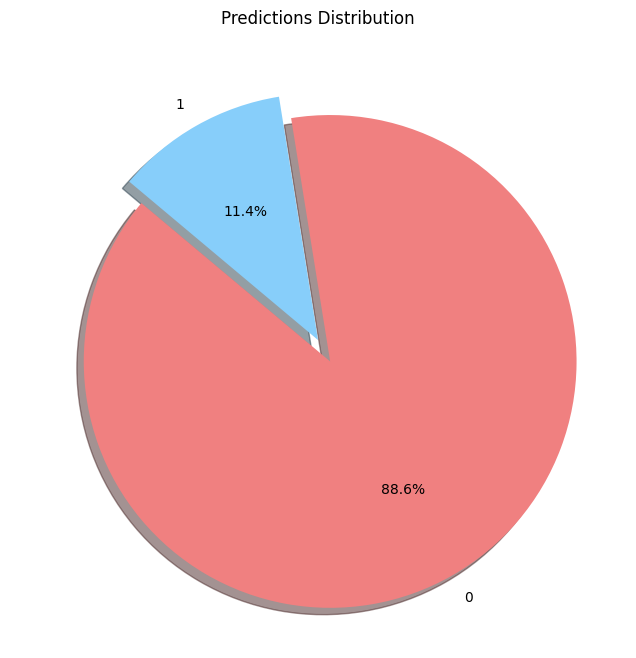

In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Flatten, Dense, Dropout, Reshape, AvgPool2D
from tensorflow.keras.models import Sequential
from sklearn.metrics import r2_score, roc_auc_score, confusion_matrix

# Reshape the data
X_train_reshaped = X_train.reshape((X_train.shape[0], X_train.shape[1], 1, 1))
X_test_reshaped = X_test.reshape((X_test.shape[0], X_test.shape[1], 1, 1))

# Define the encoder-decoder model
encoder_decoder_model = Sequential([
    # Encoder
    Conv2D(256, (3, 1), activation='relu', input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2], 1)),  # First convolutional layer
    AvgPool2D(pool_size=(2, 1)),  # First average pooling layer
    Dropout(0.25),  # First dropout layer
    Conv2D(128, (3, 1), activation='relu'),  # Second convolutional layer
    AvgPool2D(pool_size=(2, 1)),  # Second average pooling layer
    Dropout(0.25),  # Second dropout layer
    Conv2D(64, (3, 1), activation='relu'),  # Third convolutional layer
    AvgPool2D(pool_size=(2, 1)),  # Third average pooling layer
    Dropout(0.25),  # Third dropout layer
    Flatten(),  # Flatten the data for the dense layers
    Dense(512, activation='relu'),  # First dense layer
    Dropout(0.5),  # Fourth dropout layer
    Dense(256, activation='relu'),  # Second dense layer
    Dropout(0.5),  # Fifth dropout layer
    
    # Decoder
    Reshape((8, 1, 32)),  # Reshape to match the input shape of the decoder
    UpSampling2D(size=(2, 1)),  # First upsampling layer
    Conv2D(64, (3, 1), activation='relu'),  # First convolutional layer in decoder
    UpSampling2D(size=(2, 1)),  # Second upsampling layer
    Conv2D(128, (3, 1), activation='relu'),  # Second convolutional layer in decoder
    UpSampling2D(size=(2, 1)),  # Third upsampling layer
    Conv2D(256, (3, 1), activation='relu'),  # Third convolutional layer in decoder
    Flatten(),  # Flatten the data for the final dense layer
    Dense(1, activation='sigmoid')  # Output layer
])

# Compile the model
encoder_decoder_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print the model summary
encoder_decoder_model.summary()

# Train the model
encoder_decoder_model.fit(X_train_reshaped, y_train, epochs=10, batch_size=32, validation_data=(X_test_reshaped, y_test))

# Evaluate the model
loss, accuracy = encoder_decoder_model.evaluate(X_test_reshaped, y_test)
print(f'Loss: {loss}, Accuracy: {accuracy}')

# Predict probabilities for the test set
y_pred_prob = encoder_decoder_model.predict(X_test_reshaped)

# Apply threshold of 0.5 to get binary predictions
y_pred = (y_pred_prob > 0.5).astype(int)

# Calculate R² score
r2 = r2_score(y_test, y_pred)

# Calculate ROC AUC score
roc_auc = roc_auc_score(y_test, y_pred_prob)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Print the results
print(f'R² Score: {r2}')
print(f'ROC AUC Score: {roc_auc}')
print('Confusion Matrix:')
print(conf_matrix)

# Load the test.csv file
test = pd.read_csv('test.csv')
print(test.head())

# Define the features (assuming features is already defined)
features = ['person_age', 'person_income', 'person_home_ownership', 'person_emp_length',
            'loan_intent', 'loan_grade', 'loan_amnt', 'loan_int_rate', 'loan_percent_income',
            'cb_person_default_on_file', 'cb_person_cred_hist_length']

# Extract IDs and features
ids = test['id']  # Assuming 'id' is the column name for IDs in the test.csv file
X = test[features]

# Preprocess the data
X = preprocessor.transform(X)

# Predict the values using encoder_decoder_model
y_pred = encoder_decoder_model.predict(X.reshape((X.shape[0], X.shape[1], 1, 1)))

# Apply threshold of 0.5 to get binary predictions
y_pred = (y_pred > 0.5).astype(int)
print(y_pred.shape, y_pred.flatten().shape)

# Combine IDs and predictions into a DataFrame
predictions_df = pd.DataFrame({'id': ids, 'prediction': y_pred.flatten()})

# Print the DataFrame
print(predictions_df)

# Count the number of predictions greater than 0.5 and less than or equal to 0.5
count_greater_than_0_5 = (y_pred > 0.5).sum()
count_less_than_or_equal_0_5 = (y_pred <= 0.5).sum()

# Print the counts
print(f'Number of predictions greater than 0.5: {count_greater_than_0_5}')
print(f'Number of predictions less than or equal to 0.5: {count_less_than_or_equal_0_5}')

# Plot a pie chart showing the percentages
labels = ['0', '1']
sizes = [count_less_than_or_equal_0_5, count_greater_than_0_5]
colors = ['lightcoral', 'lightskyblue']
explode = (0.1, 0)  # explode the first slice

plt.figure(figsize=(8, 8))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
plt.title('Predictions Distribution')
plt.show()

# Save the predictions to CSV with (id, prediction)
predictions_df.to_csv('convmax.csv', index=False)

C:\Users\death\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_34 (Conv2D)              │ (None, 24, 1, 64)      │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_12            │ (None, 12, 1, 64)      │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_40 (Dropout)            │ (None, 12, 1, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_35 (Conv2D)              │ (None, 10, 1, 32)      │         6,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_13            │ (None, 5, 1, 32)       │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_41 (Dropout)            │ (None, 5, 1, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_12 (Flatten)            │ (None, 160)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_72 (Dense)                │ (None, 128)            │        20,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_42 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_73 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_43 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_2 (Reshape)             │ (None, 8, 1, 8)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_6 (UpSampling2D)  │ (None, 16, 1, 8)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_36 (Conv2D)              │ (None, 14, 1, 32)      │           800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_7 (UpSampling2D)  │ (None, 28, 1, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_37 (Conv2D)              │ (None, 26, 1, 64)      │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_13 (Flatten)            │ (None, 1664)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_74 (Dense)                │ (None, 1)              │         1,665 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 43,969 (171.75 KB)

 Trainable params: 43,969 (171.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1283/1283 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.8800 - loss: 0.3199 - val_accuracy: 0.9190 - val_loss: 0.2532
Epoch 2/10
1283/1283 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9153 - loss: 0.2404 - val_accuracy: 0.9252 - val_loss: 0.2279
Epoch 3/10
1283/1283 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9226 - loss: 0.2304 - val_accuracy: 0.9251 - val_loss: 0.2358
Epoch 4/10
1283/1283 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9266 - loss: 0.2208 - val_accuracy: 0.9340 - val_loss: 0.2255
Epoch 5/10
1283/1283 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.9293 - loss: 0.2150 - val_accuracy: 0.9344 - val_loss: 0.2101
Epoch 6/10
1283/1283 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.9315 - loss: 0.2133 - val_accuracy: 0.9279 - val_loss: 0.2290
Epoch 7/10
1283/1283 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.9337 - loss: 0.2046 - val_accuracy: 0.9274 - val_loss: 0.2303
Epoch 8/10
1283/1283 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.9352 - loss: 0.2044 - 

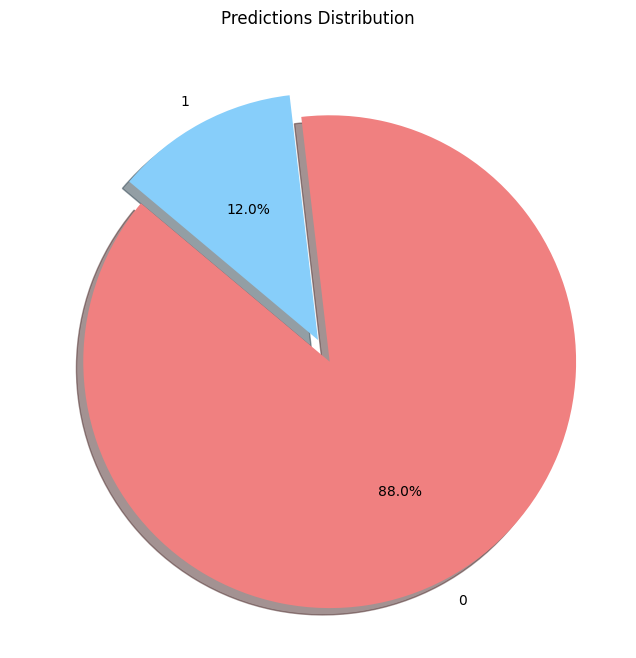

In [34]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Flatten, Dense, Dropout, Reshape, AvgPool2D
from tensorflow.keras.models import Sequential
from sklearn.metrics import r2_score, roc_auc_score, confusion_matrix

# Reshape the data
X_train_reshaped = X_train.reshape((X_train.shape[0], X_train.shape[1], 1, 1))
X_test_reshaped = X_test.reshape((X_test.shape[0], X_test.shape[1], 1, 1))

# Define the smaller encoder-decoder model
encoder_decoder_model = Sequential([
    # Encoder
    Conv2D(64, (3, 1), activation='relu', input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2], 1)),  # First convolutional layer
    AvgPool2D(pool_size=(2, 1)),  # First average pooling layer
    Dropout(0.25),  # First dropout layer
    Conv2D(32, (3, 1), activation='relu'),  # Second convolutional layer
    AvgPool2D(pool_size=(2, 1)),  # Second average pooling layer
    Dropout(0.25),  # Second dropout layer
    Flatten(),  # Flatten the data for the dense layers
    Dense(128, activation='relu'),  # First dense layer
    Dropout(0.5),  # Third dropout layer
    Dense(64, activation='relu'),  # Second dense layer
    Dropout(0.5),  # Fourth dropout layer
    
    # Decoder
    Reshape((8, 1, 8)),  # Reshape to match the input shape of the decoder
    UpSampling2D(size=(2, 1)),  # First upsampling layer
    Conv2D(32, (3, 1), activation='relu'),  # First convolutional layer in decoder
    UpSampling2D(size=(2, 1)),  # Second upsampling layer
    Conv2D(64, (3, 1), activation='relu'),  # Second convolutional layer in decoder
    Flatten(),  # Flatten the data for the final dense layer
    Dense(1, activation='sigmoid')  # Output layer
])

# Compile the model
encoder_decoder_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print the model summary
encoder_decoder_model.summary()

# Train the model
encoder_decoder_model.fit(X_train_reshaped, y_train, epochs=10, batch_size=32, validation_data=(X_test_reshaped, y_test))

# Evaluate the model
loss, accuracy = encoder_decoder_model.evaluate(X_test_reshaped, y_test)
print(f'Loss: {loss}, Accuracy: {accuracy}')

# Predict probabilities for the test set
y_pred_prob = encoder_decoder_model.predict(X_test_reshaped)

# Apply threshold of 0.5 to get binary predictions
y_pred = (y_pred_prob > 0.5).astype(int)

# Calculate R² score
r2 = r2_score(y_test, y_pred)

# Calculate ROC AUC score
roc_auc = roc_auc_score(y_test, y_pred_prob)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Print the results
print(f'R² Score: {r2}')
print(f'ROC AUC Score: {roc_auc}')
print('Confusion Matrix:')
print(conf_matrix)

# Load the test.csv file
test = pd.read_csv('test.csv')
print(test.head())

# Define the features (assuming features is already defined)
features = ['person_age', 'person_income', 'person_home_ownership', 'person_emp_length',
            'loan_intent', 'loan_grade', 'loan_amnt', 'loan_int_rate', 'loan_percent_income',
            'cb_person_default_on_file', 'cb_person_cred_hist_length']

# Extract IDs and features
ids = test['id']  # Assuming 'id' is the column name for IDs in the test.csv file
X = test[features]

# Preprocess the data
X = preprocessor.transform(X)

# Predict the values using encoder_decoder_model
y_pred = encoder_decoder_model.predict(X.reshape((X.shape[0], X.shape[1], 1, 1)))

# Apply threshold of 0.5 to get binary predictions
y_pred = (y_pred > 0.5).astype(int)
print(y_pred.shape, y_pred.flatten().shape)

# Combine IDs and predictions into a DataFrame
predictions_df = pd.DataFrame({'id': ids, 'prediction': y_pred.flatten()})

# Print the DataFrame
print(predictions_df)

# Count the number of predictions greater than 0.5 and less than or equal to 0.5
count_greater_than_0_5 = (y_pred > 0.5).sum()
count_less_than_or_equal_0_5 = (y_pred <= 0.5).sum()

# Print the counts
print(f'Number of predictions greater than 0.5: {count_greater_than_0_5}')
print(f'Number of predictions less than or equal to 0.5: {count_less_than_or_equal_0_5}')

# Plot a pie chart showing the percentages
labels = ['0', '1']
sizes = [count_less_than_or_equal_0_5, count_greater_than_0_5]
colors = ['lightcoral', 'lightskyblue']
explode = (0.1, 0)  # explode the first slice

plt.figure(figsize=(8, 8))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
plt.title('Predictions Distribution')
plt.show()

# Save the predictions to CSV with (id, prediction)
predictions_df.to_csv('encodermin.csv', index=False)

In [38]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, Reshape
from tensorflow.keras.models import Model
from sklearn.metrics import r2_score, roc_auc_score, confusion_matrix

# Reshape the data
X_train_reshaped = X_train.reshape((X_train.shape[0], X_train.shape[1]))
X_test_reshaped = X_test.reshape((X_test.shape[0], X_test.shape[1]))

# Define the autoencoder model
input_layer = Input(shape=(X_train_reshaped.shape[1],))
encoded = Dense(128, activation='relu')(input_layer)
encoded = Dropout(0.25)(encoded)
encoded = Dense(64, activation='relu')(encoded)
encoded = Dropout(0.25)(encoded)
encoded = Dense(32, activation='relu')(encoded)
encoded = Dropout(0.25)(encoded)

latent_space = Dense(16, activation='relu')(encoded)

decoded = Dense(32, activation='relu')(latent_space)
decoded = Dropout(0.25)(decoded)
decoded = Dense(64, activation='relu')(decoded)
decoded = Dropout(0.25)(decoded)
decoded = Dense(128, activation='relu')(decoded)
decoded = Dropout(0.25)(decoded)
output_layer = Dense(X_train_reshaped.shape[1], activation='sigmoid')(decoded)

autoencoder = Model(input_layer, output_layer)

# Compile the model
autoencoder.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print the model summary
autoencoder.summary()

# Train the model
autoencoder.fit(X_train_reshaped, X_train_reshaped, epochs=1, batch_size=32, validation_data=(X_test_reshaped, X_test_reshaped))

# Evaluate the model
loss, accuracy = autoencoder.evaluate(X_test_reshaped, X_test_reshaped)
print(f'Loss: {loss}, Accuracy: {accuracy}')

# Predict probabilities for the test set
y_pred_prob = autoencoder.predict(X_test_reshaped)

# Apply threshold of 0.5 to get binary predictions
y_pred = (y_pred_prob > 0.5).astype(int)

# Calculate R² score

# Calculate ROC AUC score




r2 = r2_score(y_test, y_pred)

# Calculate ROC AUC score
roc_auc = roc_auc_score(y_test, y_pred_prob)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)



# Calculate confusion matrix
conf_matrix = confusion_matrix(X_test_reshaped.argmax(axis=1), y_pred.argmax(axis=1))

# Print the results
print(f'R² Score: {r2}')
print(f'ROC AUC Score: {roc_auc}')
print('Confusion Matrix:')
print(conf_matrix)

# Load the test.csv file
test = pd.read_csv('test.csv')
print(test.head())

# Define the features (assuming features is already defined)
features = ['person_age', 'person_income', 'person_home_ownership', 'person_emp_length',
            'loan_intent', 'loan_grade', 'loan_amnt', 'loan_int_rate', 'loan_percent_income',
            'cb_person_default_on_file', 'cb_person_cred_hist_length']

# Extract IDs and features
ids = test['id']  # Assuming 'id' is the column name for IDs in the test.csv file
X = test[features]

# Preprocess the data
X = preprocessor.transform(X)

# Predict the values using the autoencoder model
y_pred = autoencoder.predict(X)

# Apply threshold of 0.5 to get binary predictions
y_pred = (y_pred > 0.5).astype(int)
print(y_pred.shape, y_pred.flatten().shape)

# Combine IDs and predictions into a DataFrame
predictions_df = pd.DataFrame({'id': ids, 'prediction': y_pred.flatten()})

# Print the DataFrame
print(predictions_df)

# Count the number of predictions greater than 0.5 and less than or equal to 0.5
count_greater_than_0_5 = (y_pred > 0.5).sum()
count_less_than_or_equal_0_5 = (y_pred <= 0.5).sum()

# Print the counts
print(f'Number of predictions greater than 0.5: {count_greater_than_0_5}')
print(f'Number of predictions less than or equal to 0.5: {count_less_than_or_equal_0_5}')

# Plot a pie chart showing the percentages
labels = ['0', '1']
sizes = [count_less_than_or_equal_0_5, count_greater_than_0_5]
colors = ['lightcoral', 'lightskyblue']
explode = (0.1, 0)  # explode the first slice

plt.figure(figsize=(8, 8))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
plt.title('Predictions Distribution')
plt.show()

# Save the predictions to CSV with (id, prediction)
predictions_df.to_csv('automid.csv', index=False)

Model: "functional_85"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_22 (InputLayer)     │ (None, 26)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_99 (Dense)                │ (None, 128)            │         3,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_62 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_100 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_63 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_101 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_64 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_102 (Dense)               │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_103 (Dense)               │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_65 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_104 (Dense)               │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_66 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_105 (Dense)               │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_67 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_106 (Dense)               │ (None, 26)             │         3,354 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 28,650 (111.91 KB)

 Trainable params: 28,650 (111.91 KB)

 Non-trainable params: 0 (0.00 B)

1283/1283 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.0419 - loss: -14297441763328.0000 - val_accuracy: 0.0322 - val_loss: -1156361425518592.0000
550/550 ━━━━━━━━━━━━━━━━━━━━ 0s 618us/step - accuracy: 0.0321 - loss: -1153166775156736.0000
Loss: -1156361425518592.0, Accuracy: 0.03222689405083656
550/550 ━━━━━━━━━━━━━━━━━━━━ 0s 744us/step


ValueError: y_true and y_pred have different number of output (1!=26)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import r2_score, roc_auc_score, confusion_matrix

# Load the test.csv file
test = pd.read_csv('test.csv')
print(test.head())

# Define the features (assuming features is already defined)
features = ['person_age', 'person_income', 'person_home_ownership', 'person_emp_length',
            'loan_intent', 'loan_grade', 'loan_amnt', 'loan_int_rate', 'loan_percent_income',
            'cb_person_default_on_file', 'cb_person_cred_hist_length']

# Extract IDs and features
ids = test['id']  # Assuming 'id' is the column name for IDs in the test.csv file
X = test[features]

# Preprocess the data
X = preprocessor.transform(X)

# Predict the values using convmodel2
y_pred = convmodel2.predict(X.reshape((X.shape[0], X.shape[1], 1, 1)))

# Apply threshold of 0.5 to get binary predictions
y_pred = (y_pred > 0.5).astype(int)
print(y_pred.shape, y_pred.flatten().shape)

# Combine IDs and predictions into a DataFrame
predictions_df = pd.DataFrame({'id': ids, 'prediction': y_pred.flatten()})

# Print the DataFrame
print(predictions_df)

# Count the number of predictions greater than 0.5 and less than or equal to 0.5
count_greater_than_0_5 = (y_pred > 0.5).sum()
count_less_than_or_equal_0_5 = (y_pred <= 0.5).sum()

# Print the counts
print(f'Number of predictions greater than 0.5: {count_greater_than_0_5}')
print(f'Number of predictions less than or equal to 0.5: {count_less_than_or_equal_0_5}')

# Plot a pie chart showing the percentages
labels = ['0', '1']
sizes = [count_less_than_or_equal_0_5, count_greater_than_0_5]
colors = ['lightcoral', 'lightskyblue']
explode = (0.1, 0)  # explode the first slice

plt.figure(figsize=(8, 8))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
plt.title('Predictions Distribution')
plt.show()

# Save the predictions to CSV with (id, prediction)
predictions_df.to_csv('conv3.csv', index=False)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import r2_score, roc_auc_score, confusion_matrix
import pandas as pd

# Load the test.csv file
test = pd.read_csv('test.csv')
print(test.head())

# Define the features (assuming features is already defined)
features = ['person_age', 'person_income', 'person_home_ownership', 'person_emp_length',
            'loan_intent', 'loan_grade', 'loan_amnt', 'loan_int_rate', 'loan_percent_income',
            'cb_person_default_on_file', 'cb_person_cred_hist_length']

# Extract IDs and features
ids = test['id']  # Assuming 'id' is the column name for IDs in the test.csv file
X = test[features]

# Preprocess the data
X = preprocessor.transform(X)

# Predict the values using the model
model = tf.keras.models.load_model('bm.keras')
# Clip the predictions to 0 or 1 based on the threshold of 0.5
y_pred = model.predict(X)
#apply threshold
y_pred = (y_pred > 0.5).astype(int)
print(y_pred.shape,y_pred.flatten().shape)
# Combine IDs and predictions into a DataFrame
predictions_df = pd.DataFrame({'id': ids, 'prediction': y_pred.flatten()})

# Print the DataFrame
print(predictions_df)

# Count the number of predictions greater than 0.5 and less than or equal to 0.5
count_greater_than_0_5 = (y_pred > 0.5).sum()
count_less_than_or_equal_0_5 = (y_pred <= 0.5).sum()

# Print the counts
print(f'Number of predictions greater than 0.5: {count_greater_than_0_5}')
print(f'Number of predictions less than or equal to 0.5: {count_less_than_or_equal_0_5}')

# Plot a pie chart showing the percentages
labels = ['0', '1']
sizes = [count_less_than_or_equal_0_5, count_greater_than_0_5]
colors = ['lightcoral', 'lightskyblue']
explode = (0.1, 0)  # explode the first slice

plt.figure(figsize=(8, 8))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
plt.title('Predictions Distribution')
plt.show()
#save the predictions to csv with (id,prediction)

predictions_df.to_csv('predictions.csv', index=False)

Model: "functional_82"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_19 (InputLayer)     │ (None, 26)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_75 (Dense)                │ (None, 128)            │         3,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_44 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_76 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_45 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_77 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_46 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_78 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_79 (Dense)                │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_47 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_80 (Dense)                │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_48 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_81 (Dense)                │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_49 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_82 (Dense)                │ (None, 26)             │         3,354 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 28,650 (111.91 KB)

 Trainable params: 28,650 (111.91 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1283/1283 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.0460 - loss: -9833063383040.0000 - val_accuracy: 0.0323 - val_loss: -800001278083072.0000
Epoch 2/10
1283/1283 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.0618 - loss: -9343568208461824.0000 - val_accuracy: 0.0323 - val_loss: -122887776071843840.0000
Epoch 3/10
1283/1283 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.0670 - loss: -330687811499851776.0000 - val_accuracy: 0.0323 - val_loss: -1686683684918263808.0000
Epoch 4/10
1283/1283 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.0603 - loss: -3064376564884963328.0000 - val_accuracy: 0.2699 - val_loss: -9807296274087542784.0000
Epoch 5/10
1283/1283 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.0623 - loss: -14775443962239909888.0000 - val_accuracy: 0.0323 - val_loss: -36851073386866016256.0000
Epoch 6/10
1283/1283 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.0695 - loss: -50898350380448481280.0000 - val_accuracy: 0.0323 - val_loss: -106679007377245601792.0000
Ep

ValueError: continuous-multioutput format is not supported